# HW02: EDA как оно есть.

## Загрузка данных
Загрузим датасет и посмотрим первые строки, чтобы убедиться, что данные читаются корректно.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.size'] = 12

data_path = "S02-hw-dataset.csv"

df = pd.read_csv(data_path)

df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


## Структура датасета
Посмотрим типы столбцов и количество непустых значений.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


Мы видим, что в столбце `age` присутствуют пропуски. Перед дальнейшим анализом их нужно обработать.

## Пропуски данных
Определим долю пропусков в каждом столбце.

In [23]:
missing = df.isna().mean()
missing

user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

Пропуски присутствуют только в возрасте. Для EDA мы можем удалить строки с пропусками, чтобы не искажать статистику.

Ну а теперь избавимся от них! :D

In [24]:
df_clean = df.dropna().copy()
df_clean.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
5,6,120.0,FR,-1,785


## Проверка дубликатов

In [25]:
duplicates = df_clean[df_clean.duplicated()]
duplicates

,user_id,age,country,purchases,revenue
40,10,24.0,RU,7,511


Удалим их, чтобы они не создавали помех в анализе

In [26]:
df_clean = df_clean.drop_duplicates().copy()

## Описательные статистики
Быстрый способ понять диапазоны значений и возможные аномалии.

In [27]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


## Поиск аномальных значений
Проверим отрицательные значения, нереалистичные возраста и странные комбинации признаков.

In [28]:
negative_purchases = df_clean[df_clean['purchases'] < 0]
weird_age = df_clean[(df_clean['age'] < 14) | (df_clean['age'] > 100)]
zero_revenue = df_clean[(df_clean['purchases'] > 0) & (df_clean['revenue'] == 0)]

negative_purchases, weird_age, zero_revenue

(   user_id    age country  purchases  revenue
 5        6  120.0      FR         -1      785,
     user_id    age country  purchases  revenue
 5         6  120.0      FR         -1      785
 20       21    5.0      RU          8     1488,
     user_id   age country  purchases  revenue
 10       11  24.0      US          4        0)

Мы обнаружили аномалии. В рамках проекта просто удалим данные значения, дабы они не мешали нашему анализу

In [29]:
df_clean = df_clean[
    (df_clean['purchases'] >= 0) &
    (df_clean['age'] >= 14) &
    (df_clean['age'] <= 100)
].copy()
df_clean.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
6,7,46.0,RU,0,0


## Распределение по странам
Посмотрим, сколько пользователей представлено из каждой страны.

In [30]:
country_counts = df_clean['country'].value_counts()
country_counts

country
FR    11
RU    11
US     7
DE     5
CN     2
Name: count, dtype: int64

Размера датасета небольшие, а объём категориальных данных - ещё меньше, это безусловно будет создавать нам проблемы при построении графиков, но тут ничего не сделать

## Агрегаты по странам
Рассмотрим ключевые статистики: количество пользователей, среднее и медианы.

In [31]:
aggregates = (
    df_clean
    .groupby("country")[["purchases", "revenue"]]
    .agg(["count", "mean", "median"])
    .round(2)
)

aggregates

purchases              revenue                
            count  mean median   count    mean  median
country                                               
CN              2  4.50    4.5       2  1054.0  1054.0
DE              5  6.60    6.0       5  1475.4  1104.0
FR             11  4.73    6.0      11   666.0   546.0
RU             11  4.27    5.0      11   752.0   650.0
US              7  4.00    4.0       7   547.0   445.0

 Германия и Китай выглядят самыми прибыльными странами, но репрезентативность наших данных не позволяет делать столь смелые заявления

## Папка для графиков

Воспользуемся библиотекой `os` и создадим папочку (в терминале делать лень :D)

In [32]:
os.makedirs('figures', exist_ok=True)

## Гистограмма возрастов
Рассмотрим распределение пользователей по возрасту.

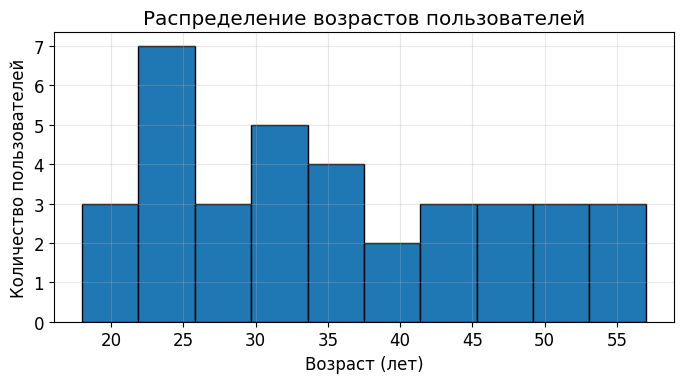

In [33]:
plt.figure()

ages = df_clean['age']

plt.hist(ages, bins=10, edgecolor='black')

plt.xlabel('Возраст (лет)')
plt.ylabel('Количество пользователей')
plt.title('Распределение возрастов пользователей')

plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('figures/age_hist.png', dpi=300)
plt.show()

Распределение достаточно равномерное, но наибольшей группой представляются пользователи 25 и 35 лет

## Boxplot выручки по странам
Оценим разброс выручки для каждой страны.

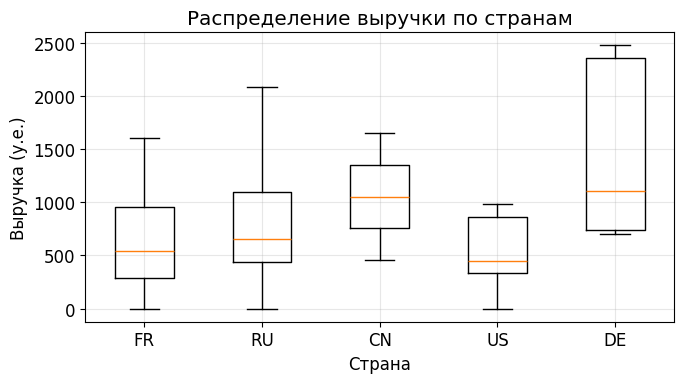

In [34]:
plt.figure()

countries = df_clean['country'].unique()
data_by_country = [df_clean[df_clean['country'] == c]['revenue'] for c in countries]

plt.boxplot(data_by_country, tick_labels=countries)

plt.xlabel('Страна')
plt.ylabel('Выручка (у.е.)')
plt.title('Распределение выручки по странам')

plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('figures/revenue_boxplot_by_country.png', dpi=300)
plt.show()

Как и ожидалось, вследствие малого количества данных, мы видим большие размахи Q1 Q3 у Германии, а так же большие межквантильные размахи у России. Тем не менее, медианы у Китая и Германии самые большие

## Scatter: зависимость выручки от числа покупок
Построим диаграмму рассеяния и визуально оценим связь.

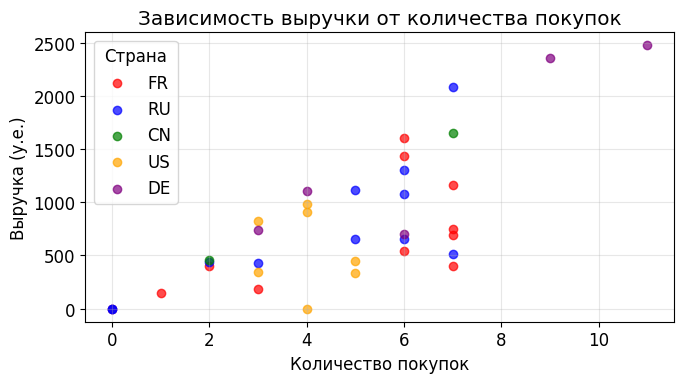

In [35]:
plt.figure()

countries = df_clean['country'].unique()
colors = ['red', 'blue', 'green', 'orange', 'purple']

for country, color in zip(countries, colors):
    subset = df_clean[df_clean['country'] == country]

    plt.scatter(
        subset['purchases'],
        subset['revenue'],
        label=country,
        color=color,
        alpha=0.7
    )

plt.xlabel('Количество покупок')
plt.ylabel('Выручка (у.е.)')
plt.title('Зависимость выручки от количества покупок')

plt.legend(title='Страна')
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig('figures/revenue_vs_purchases_scatter.png', dpi=300)
plt.show()


Наблюдается явная положительная зависимость. Больше покупок -> больше выручка. Что логично.

## Корреляционная матрица

Построим небольшую корреляционную матрицу

In [36]:
corr = df_clean[['age', 'purchases', 'revenue']].corr()
corr

,age,purchases,revenue
age,1.000000,-0.037837,-0.051462
purchases,-0.037837,1.000000,0.749281
revenue,-0.051462,0.749281,1.000000




Мы видим почти полное отсутствие зависимости количества лет от количества покупок, а зависимость выручки от числа покупок подтверждает наши выводы выше

## Итог анализа

После очистки данных и рассмотрения основных зависимостей можно сделать следующие выводы:

* Данные содержали пропуски, дубликаты и аномалии — мы корректно их обработали.
* Выручка и количество покупок имеют устойчивую положительную зависимость.
* Возраст почти не влияет на поведение пользователей.
* Некоторые страны показывают более высокие средние чеки, но выборки малы, поэтому выводы предварительные.

